In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import os

#model creation
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.applications import inception_v3
from keras.applications import VGG16 # build up model
from keras.applications import vgg16 # pre-train model functions
from keras.applications import VGG19 # build up model
from keras.applications import vgg19 # pre-train model functions
from keras.models import Model
from keras import Sequential
from keras import callbacks

#image preprocessing
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#load model
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # dataset too large so need to use google drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
cd  content/gdrive/My\ Drive/Cap_project

/content/gdrive/.shortcut-targets-by-id/1NZh4JXY9LfT3Ip7M2UoHIdUT5zMd-bbI/Cap_project


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
!ls /mydrive/Xccelerate\ Capstone/

Capstone_Project.zip  category.zip  color.zip  patterns.zip  samples_floral.zip


In [ ]:
!cp /mydrive/Xccelerate\ Capstone/category.zip /content/
!cp /mydrive/Xccelerate\ Capstone/patterns.zip /content/
!cp /mydrive/Xccelerate\ Capstone/color.zip /content/

In [11]:
!unzip category.zip 
!unzip patterns.zip 
!unzip color.zip 

串流輸出內容已截斷至最後 5000 行。
  inflating: category/tops/gap-0511-5036745-1.jpg  
  inflating: __MACOSX/category/tops/._gap-0511-5036745-1.jpg  
  inflating: category/tops/zalora-0401-4181925-1.jpg  
  inflating: __MACOSX/category/tops/._zalora-0401-4181925-1.jpg  
  inflating: category/tops/mango-4729-9936545-1.jpg  
  inflating: __MACOSX/category/tops/._mango-4729-9936545-1.jpg  
  inflating: category/tops/yoco-3041-1128935-1.jpg  
  inflating: __MACOSX/category/tops/._yoco-3041-1128935-1.jpg  
  inflating: category/tops/ellesse-4394-8297435-1.jpg  
  inflating: __MACOSX/category/tops/._ellesse-4394-8297435-1.jpg  
  inflating: category/tops/zalora-basics-2734-4729525-1.jpg  
  inflating: __MACOSX/category/tops/._zalora-basics-2734-4729525-1.jpg  
  inflating: category/tops/gap-2744-0336745-1.jpg  
  inflating: __MACOSX/category/tops/._gap-2744-0336745-1.jpg  
  inflating: category/tops/forcast-3286-5422635-1.jpg  
  inflating: __MACOSX/category/tops/._forcast-3286-5422635-1.jpg  
  inflating

KeyboardInterrupt: ignored

## Create Model


In [ ]:
def Train(attribute, directory_name):
  #image augmentation for input image
  datagen = ImageDataGenerator(
          shear_range = 0.1,
          zoom_range = 0.1,
          validation_split = 0.2,
          rotation_range = 25,
          width_shift_range = 0.1,
          height_shift_range = 0.1,
          horizontal_flip = True,
          preprocessing_function = vgg19.preprocess_input) ##
  
  #generate training and validation set
  trainG = datagen.flow_from_directory(
        directory = directory_name,
        target_size = (224,224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 100,
        subset = 'training')

  ValidationG = datagen.flow_from_directory(
        directory = directory_name,
        target_size = (224,224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 100,
        subset = 'validation')
  
  #MODEL CREATION
  #create feature selection layers from pre-trained model
  base_model = VGG19(
                  include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3)) ##

  #create classification layer
  x = base_model.output
  x = Flatten()(x)
  x = Dense(128,activation='relu')(x)
  x = Dense(64,activation='relu')(x)
  x = Dropout(0.2)(x)
  predictions = Dense(len(trainG.class_indices),activation='softmax')(x)

  #link the input from base_model to the classification layers
  model = Model(inputs=base_model.input,outputs=predictions)

  #set trainable layers
  for layer in base_model.layers:
      layer.trainable = False # feature extraction don't change -- freeze
      
  #Define model compilation
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #set early-stopping criteria
  early_stopping = callbacks.EarlyStopping(monitor='val_loss',patience=3)
  checkpoint = callbacks.ModelCheckpoint(filepath='vgg19_model_{val_accuracy:.2f}_{val_loss:.2f}.h5', verbose=1, save_best_only=True)
# checkpoint saves best model but google collab - not save to local drive
  #set step-size
  STEP_SIZE_TRAIN = trainG.n // trainG.batch_size
  STEP_SIZE_VALID = ValidationG.n // ValidationG.batch_size

  #fit the model and create the history object
  hist = model.fit_generator(
              generator = trainG,
              steps_per_epoch = STEP_SIZE_TRAIN,
              validation_data = ValidationG,
              validation_steps = STEP_SIZE_VALID,
              epochs = 25,
              callbacks = [early_stopping,checkpoint]
  )

  #save the accuracy and loss for training and validation set
  epoch_range = range(1,len(hist.history['accuracy'])+1)

  plt.subplot(1,2,1)
  plt.plot(epoch_range,hist.history['accuracy'],epoch_range,hist.history['val_accuracy'])
  plt.legend(('Training accuracy','Validation accuracy'))
  plt.savefig(f'accuracy-{attribute}')

  plt.subplot(1,2,2)
  plt.plot(epoch_range,hist.history['loss'],epoch_range,hist.history['val_loss'])
  plt.legend(('Training loss','Validation loss'))
  plt.savefig(f'training-{attribute}')


## Load the trained model 

In [ ]:
category_label = ['blazers','dresses','hoodies&sweatshirts','jackets&coats','jeans','knitwear&cardigans','pants','shorts','skirts','tops']
pattern_label = ['checks', 'dots', 'floral', 'graphic', 'solid', 'stripes']
color_label = ['black&white','blue','brown','green','light_pink&beige','orange','purple','red&pink','yellow']

In [ ]:
def LOAD_model(category_model_path,pattern_model_path,color_model_path):

  model_for_category = load_model(category_model_path)
  model_for_pattern = load_model(pattern_model_path)
  model_for_color = load_model(color_model_path)

  return model_for_category,model_for_pattern,model_for_color

In [ ]:
def prediction(image_path):
  img = load_img(image_path,target_size=(224,224))
  img = img_to_array(img)
  img = vgg19.preprocess_input(img) ##
  img = np.expand_dims(img, axis=0)

  plt.imshow(load_img(image_path,target_size=(224,224)))

  prediction_all_category = model_for_category.predict(img)
  prediction_all_pattern = model_for_pattern.predict(img)
  prediction_all_color = model_for_color.predict(img)

  final_pred_category = category_label[np.argmax(prediction_all_category)]
  final_pred_pattern = pattern_label[np.argmax(prediction_all_pattern)]
  final_pred_color = color_label[np.argmax(prediction_all_color)]

  final_prediction = {'category':final_pred_category,'pattern':final_pred_pattern,'color':final_pred_color}
  return final_prediction


In [ ]:
def prediction_details(image_path):
  img = load_img(image_path,target_size=(224,224))
  img = img_to_array(img)
  img = vgg19.preprocess_input(img) ##
  img = np.expand_dims(img, axis=0)

  plt.imshow(load_img(image_path,target_size=(224,224)))

  prediction_all_category = model_for_category.predict(img)
  prediction_all_pattern = model_for_pattern.predict(img)
  prediction_all_color = model_for_color.predict(img)

  # match the classes with predicted probability
  category_dict =dict(zip(category_label,prediction_all_category[0]))
  pattern_dict =dict(zip(pattern_label,prediction_all_pattern[0]))
  color_dict =dict(zip(color_label,prediction_all_color[0]))

  # sort the classes by probability
  category_dict_ordered = sorted(category_dict.items(), key=lambda kv: kv[1],reverse=True)
  pattern_dict_ordered = sorted(pattern_dict.items(), key=lambda kv: kv[1],reverse=True)
  color_dict_ordered = sorted(color_dict.items(), key=lambda kv: kv[1],reverse=True)

  for i in range(len(category_dict_ordered)):
    print(category_dict_ordered[i][0].ljust(20,' '),'{:.2f}%'.format(category_dict_ordered[i][1]*100))
  print('')
  
  for i in range(len(pattern_dict_ordered)):
    print(pattern_dict_ordered[i][0].ljust(20,' ') ,'{:.2f}%'.format(pattern_dict_ordered[i][1]*100))
  print('')

  for i in range(len(color_dict_ordered)):
    print(color_dict_ordered[i][0].ljust(20,' '),'{:.2f}%'.format(color_dict_ordered[i][1]*100))


In [ ]:
## training and testing

Found 5320 images belonging to 9 classes.
Found 1326 images belonging to 9 classes.
80142336/80134624 [==============================] - 4s 0us/step
Epoch 1/25
53/53 [==============================] - 114s 2s/step - loss: 2.9908 - accuracy: 0.1916 - val_loss: 2.1211 - val_accuracy: 0.2546

Epoch 00001: val_loss improved from inf to 2.12115, saving model to vgg19_model_0.25_2.12.h5
Epoch 2/25
53/53 [==============================] - 109s 2s/step - loss: 1.9163 - accuracy: 0.2906 - val_loss: 1.7810 - val_accuracy: 0.3483

Epoch 00002: val_loss improved from 2.12115 to 1.78102, saving model to vgg19_model_0.35_1.78.h5
Epoch 3/25
53/53 [==============================] - 108s 2s/step - loss: 1.7679 - accuracy: 0.3651 - val_loss: 1.9322 - val_accuracy: 0.3679

Epoch 00003: val_loss did not improve from 1.78102
Epoch 4/25
53/53 [==============================] - 107s 2s/step - loss: 1.6393 - accuracy: 0.3964 - val_loss: 1.5489 - val_accuracy: 0.3891

Epoch 00004: val_loss improved from 1.7810

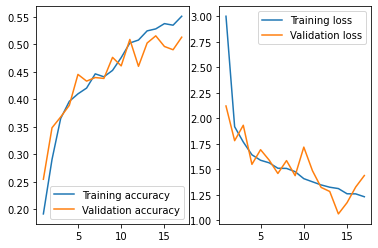

In [ ]:
Train('color', 'color')

In [ ]:
model_for_category = keras.models.load_model('vgg19_model_category_0.58_1.02.h5')
model_for_pattern = keras.models.load_model('vgg19_model_pattern_0.54_1.15.h5')
model_for_color = keras.models.load_model('vgg19_model_color_0.52_1.06.h5')

{'category': 'dresses', 'color': 'light_pink&beige', 'pattern': 'solid'}

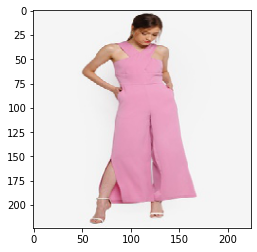

In [ ]:
prediction('pink.jpg')

{'category': 'hoodies&sweatshirts', 'color': 'blue', 'pattern': 'graphic'}

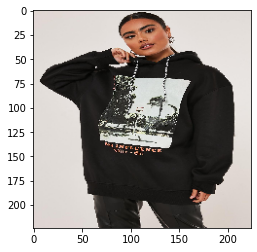

In [ ]:
prediction('hoodie.jpg')

{'category': 'jackets&coats', 'color': 'green', 'pattern': 'solid'}

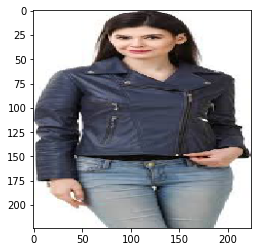

In [ ]:
prediction('jacket.jpg')

hoodies&sweatshirts  99.77%
jackets&coats        0.23%
pants                0.00%
jeans                0.00%
knitwear&cardigans   0.00%
tops                 0.00%
blazers              0.00%
skirts               0.00%
dresses              0.00%
shorts               0.00%

graphic              91.97%
floral               7.91%
solid                0.06%
stripes              0.04%
dots                 0.01%
checks               0.00%

blue                 54.64%
green                20.93%
black&white          17.18%
light_pink&beige     5.39%
purple               1.76%
red&pink             0.06%
yellow               0.03%
brown                0.01%
orange               0.00%


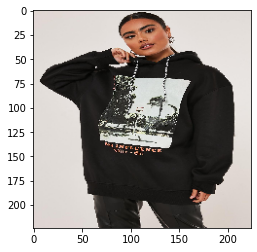

In [ ]:
prediction_details('hoodie.jpg')

dresses              54.60%
jackets&coats        20.71%
knitwear&cardigans   12.12%
skirts               6.04%
tops                 3.02%
pants                2.17%
blazers              0.66%
hoodies&sweatshirts  0.63%
jeans                0.05%
shorts               0.01%

solid                80.66%
stripes              6.25%
floral               4.63%
checks               3.85%
dots                 3.30%
graphic              1.30%

light_pink&beige     47.49%
orange               21.88%
red&pink             17.04%
yellow               7.29%
blue                 2.86%
black&white          1.24%
purple               1.18%
brown                0.53%
green                0.49%


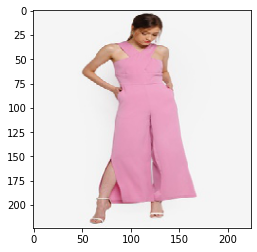

In [ ]:
prediction_details('pink.jpg')

jackets&coats        76.10%
knitwear&cardigans   12.63%
hoodies&sweatshirts  4.49%
blazers              3.87%
tops                 1.59%
pants                1.20%
jeans                0.11%
dresses              0.00%
skirts               0.00%
shorts               0.00%

solid                45.59%
stripes              26.97%
graphic              16.01%
checks               8.01%
dots                 2.55%
floral               0.86%

green                71.00%
black&white          27.11%
light_pink&beige     1.48%
blue                 0.39%
purple               0.02%
yellow               0.00%
brown                0.00%
red&pink             0.00%
orange               0.00%


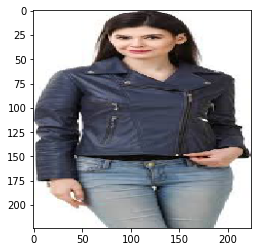

In [ ]:
prediction_details('jacket.jpg')

pants                97.56%
jeans                1.98%
skirts               0.34%
shorts               0.12%
blazers              0.00%
dresses              0.00%
knitwear&cardigans   0.00%
tops                 0.00%
hoodies&sweatshirts  0.00%
jackets&coats        0.00%

stripes              71.87%
dots                 17.58%
graphic              4.63%
solid                4.30%
checks               1.02%
floral               0.60%

black&white          49.68%
blue                 34.32%
green                13.09%
purple               2.66%
light_pink&beige     0.15%
red&pink             0.08%
brown                0.01%
yellow               0.00%
orange               0.00%


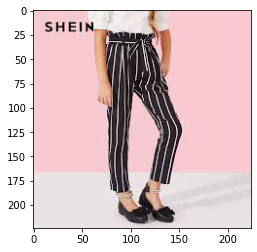

In [ ]:
prediction_details('pants.jpg')

shorts               50.04%
dresses              25.48%
skirts               24.28%
pants                0.13%
knitwear&cardigans   0.05%
tops                 0.01%
jeans                0.00%
blazers              0.00%
hoodies&sweatshirts  0.00%
jackets&coats        0.00%

floral               99.70%
graphic              0.29%
dots                 0.01%
checks               0.00%
solid                0.00%
stripes              0.00%

green                21.73%
orange               15.64%
red&pink             14.06%
black&white          13.42%
blue                 11.02%
yellow               8.25%
light_pink&beige     7.83%
purple               5.31%
brown                2.73%


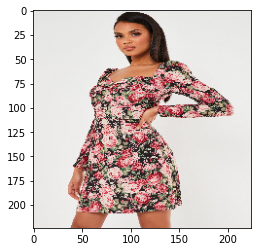

In [ ]:
prediction_details('floral.jpg')

jackets&coats        33.54%
knitwear&cardigans   33.43%
blazers              31.08%
tops                 1.86%
pants                0.07%
hoodies&sweatshirts  0.03%
dresses              0.00%
jeans                0.00%
skirts               0.00%
shorts               0.00%

dots                 74.70%
floral               13.00%
graphic              12.29%
checks               0.01%
solid                0.00%
stripes              0.00%

black&white          43.51%
green                37.79%
blue                 12.42%
light_pink&beige     3.39%
purple               2.56%
brown                0.23%
red&pink             0.06%
yellow               0.03%
orange               0.00%


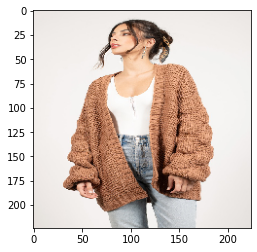

In [ ]:
prediction_details('cardigan.jpg')

skirts               34.77%
dresses              20.61%
shorts               16.52%
knitwear&cardigans   11.63%
pants                7.16%
tops                 2.63%
hoodies&sweatshirts  2.51%
jeans                1.66%
jackets&coats        1.52%
blazers              0.99%

checks               62.48%
solid                11.59%
stripes              10.02%
graphic              7.35%
dots                 4.39%
floral               4.18%

blue                 23.02%
green                21.03%
light_pink&beige     19.17%
black&white          16.11%
purple               8.09%
yellow               4.70%
red&pink             4.18%
brown                2.80%
orange               0.91%


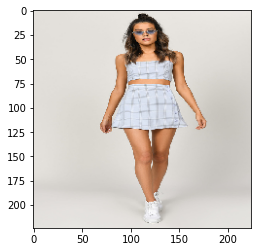

In [ ]:
prediction_details('skirt.jpg')

skirts               34.56%
knitwear&cardigans   24.18%
dresses              23.52%
jackets&coats        9.85%
pants                5.04%
tops                 1.31%
hoodies&sweatshirts  1.12%
shorts               0.15%
blazers              0.14%
jeans                0.13%

stripes              73.96%
checks               20.64%
graphic              4.71%
solid                0.59%
dots                 0.08%
floral               0.03%

blue                 52.15%
green                24.50%
purple               9.00%
black&white          7.39%
red&pink             3.32%
light_pink&beige     3.28%
brown                0.32%
orange               0.03%
yellow               0.03%


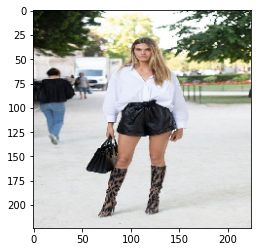

In [ ]:
#test the prediction with background
prediction_details('background.jpg')

hoodies&sweatshirts  35.24%
knitwear&cardigans   24.41%
jackets&coats        11.13%
skirts               10.13%
shorts               6.45%
pants                5.31%
jeans                3.18%
tops                 2.00%
dresses              1.36%
blazers              0.79%

checks               99.85%
stripes              0.14%
graphic              0.00%
solid                0.00%
dots                 0.00%
floral               0.00%

black&white          57.16%
blue                 23.05%
green                13.01%
purple               5.83%
red&pink             0.60%
light_pink&beige     0.19%
brown                0.16%
orange               0.00%
yellow               0.00%


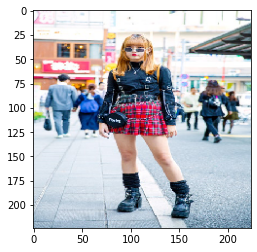

In [ ]:
prediction_details('background2.jpg')

## Tuning Model

In [ ]:
def Train(attribute, directory_name):
  #image augmentation for input image
  datagen = ImageDataGenerator(
          shear_range = 0.1,
          zoom_range = 0.1,
          validation_split = 0.2,
          rotation_range = 25,
          width_shift_range = 0.1,
          height_shift_range = 0.1,
          horizontal_flip = True,
          preprocessing_function = vgg19.preprocess_input) ##
  
  #generate training and validation set
  trainG = datagen.flow_from_directory(
        directory = directory_name,
        target_size = (224,224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 100,
        subset = 'training')

  ValidationG = datagen.flow_from_directory(
        directory = directory_name,
        target_size = (224,224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 100,
        subset = 'validation')
  
  #MODEL CREATION
  #create feature selection layers from pre-trained model
  base_model = VGG19(
                  include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3)) ##

  #create classification layer
  x = base_model.output
  x = Flatten()(x)
  x = Dense(128,activation='relu')(x)
  x = Dense(64,activation='relu')(x)
  x = Dropout(0.2)(x)
  predictions = Dense(len(trainG.class_indices),activation='softmax')(x)

  #link the input from base_model to the classification layers
  model = Model(inputs=base_model.input,outputs=predictions)

  #set trainable layers
  for layer in base_model.layers:
      layer.trainable = False # feature extraction don't change -- freeze
      
  #Define model compilation
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #set early-stopping criteria
  early_stopping = callbacks.EarlyStopping(monitor='val_loss',patience=3)
  checkpoint = callbacks.ModelCheckpoint(filepath='vgg19_model_{val_accuracy:.2f}_{val_loss:.2f}.h5', verbose=1, save_best_only=True)
# checkpoint saves best model but google collab - not save to local drive
  #set step-size
  STEP_SIZE_TRAIN = trainG.n // trainG.batch_size
  STEP_SIZE_VALID = ValidationG.n // ValidationG.batch_size

  #fit the model and create the history object
  hist = model.fit_generator(
              generator = trainG,
              steps_per_epoch = STEP_SIZE_TRAIN,
              validation_data = ValidationG,
              validation_steps = STEP_SIZE_VALID,
              epochs = 25,
              callbacks = [early_stopping,checkpoint]
  )

  #save the accuracy and loss for training and validation set
  epoch_range = range(1,len(hist.history['accuracy'])+1)

  plt.subplot(1,2,1)
  plt.plot(epoch_range,hist.history['accuracy'],epoch_range,hist.history['val_accuracy'])
  plt.legend(('Training accuracy','Validation accuracy'))
  plt.savefig(f'accuracy-{attribute}')

  plt.subplot(1,2,2)
  plt.plot(epoch_range,hist.history['loss'],epoch_range,hist.history['val_loss'])
  plt.legend(('Training loss','Validation loss'))
  plt.savefig(f'training-{attribute}')


## Load the trained tuned model 

In [ ]:
category_label = ['blazers','dresses','hoodies&sweatshirts','jackets&coats','jeans','knitwear&cardigans','pants','shorts','skirts','tops']
pattern_label = ['checks', 'dots', 'floral', 'graphic', 'solid', 'stripes']
color_label = ['black&white','blue','brown','green','light_pink&beige','orange','purple','red&pink','yellow']

In [ ]:
def LOAD_model(category_model_path,pattern_model_path,color_model_path):

  model_for_category = load_model(category_model_path)
  model_for_pattern = load_model(pattern_model_path)
  model_for_color = load_model(color_model_path)

  return model_for_category,model_for_pattern,model_for_color

In [ ]:
def prediction(image_path):
  img = load_img(image_path,target_size=(224,224))
  img = img_to_array(img)
  img = vgg19.preprocess_input(img) ##
  img = np.expand_dims(img, axis=0)

  plt.imshow(load_img(image_path,target_size=(224,224)))

  prediction_all_category = model_for_category.predict(img)
  prediction_all_pattern = model_for_pattern.predict(img)
  prediction_all_color = model_for_color.predict(img)

  final_pred_category = category_label[np.argmax(prediction_all_category)]
  final_pred_pattern = pattern_label[np.argmax(prediction_all_pattern)]
  final_pred_color = color_label[np.argmax(prediction_all_color)]

  final_prediction = {'category':final_pred_category,'pattern':final_pred_pattern,'color':final_pred_color}
  return final_prediction


In [ ]:
def prediction_details(image_path):
  img = load_img(image_path,target_size=(224,224))
  img = img_to_array(img)
  img = vgg19.preprocess_input(img) ##
  img = np.expand_dims(img, axis=0)

  plt.imshow(load_img(image_path,target_size=(224,224)))

  prediction_all_category = model_for_category.predict(img)
  prediction_all_pattern = model_for_pattern.predict(img)
  prediction_all_color = model_for_color.predict(img)

  # match the classes with predicted probability
  category_dict =dict(zip(category_label,prediction_all_category[0]))
  pattern_dict =dict(zip(pattern_label,prediction_all_pattern[0]))
  color_dict =dict(zip(color_label,prediction_all_color[0]))

  # sort the classes by probability
  category_dict_ordered = sorted(category_dict.items(), key=lambda kv: kv[1],reverse=True)
  pattern_dict_ordered = sorted(pattern_dict.items(), key=lambda kv: kv[1],reverse=True)
  color_dict_ordered = sorted(color_dict.items(), key=lambda kv: kv[1],reverse=True)

  for i in range(len(category_dict_ordered)):
    print(category_dict_ordered[i][0].ljust(20,' '),'{:.2f}%'.format(category_dict_ordered[i][1]*100))
  print('')
  
  for i in range(len(pattern_dict_ordered)):
    print(pattern_dict_ordered[i][0].ljust(20,' ') ,'{:.2f}%'.format(pattern_dict_ordered[i][1]*100))
  print('')

  for i in range(len(color_dict_ordered)):
    print(color_dict_ordered[i][0].ljust(20,' '),'{:.2f}%'.format(color_dict_ordered[i][1]*100))


In [ ]:
## training and testing

Found 5320 images belonging to 9 classes.
Found 1326 images belonging to 9 classes.
80142336/80134624 [==============================] - 4s 0us/step
Epoch 1/25
53/53 [==============================] - 114s 2s/step - loss: 2.9908 - accuracy: 0.1916 - val_loss: 2.1211 - val_accuracy: 0.2546

Epoch 00001: val_loss improved from inf to 2.12115, saving model to vgg19_model_0.25_2.12.h5
Epoch 2/25
53/53 [==============================] - 109s 2s/step - loss: 1.9163 - accuracy: 0.2906 - val_loss: 1.7810 - val_accuracy: 0.3483

Epoch 00002: val_loss improved from 2.12115 to 1.78102, saving model to vgg19_model_0.35_1.78.h5
Epoch 3/25
53/53 [==============================] - 108s 2s/step - loss: 1.7679 - accuracy: 0.3651 - val_loss: 1.9322 - val_accuracy: 0.3679

Epoch 00003: val_loss did not improve from 1.78102
Epoch 4/25
53/53 [==============================] - 107s 2s/step - loss: 1.6393 - accuracy: 0.3964 - val_loss: 1.5489 - val_accuracy: 0.3891

Epoch 00004: val_loss improved from 1.7810

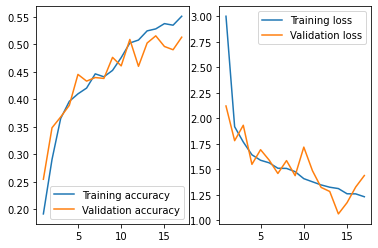

In [ ]:
Train('color', 'color')

In [ ]:
model_for_category = keras.models.load_model('vgg19_model_category_0.58_1.02.h5')
model_for_pattern = keras.models.load_model('vgg19_model_pattern_0.54_1.15.h5')
model_for_color = keras.models.load_model('vgg19_model_color_0.52_1.06.h5')

{'category': 'dresses', 'color': 'light_pink&beige', 'pattern': 'solid'}

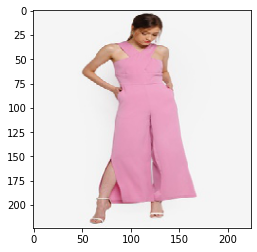

In [ ]:
prediction('pink.jpg')

{'category': 'hoodies&sweatshirts', 'color': 'blue', 'pattern': 'graphic'}

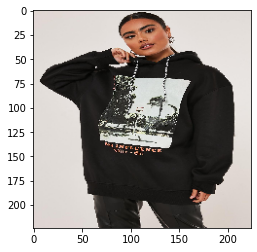

In [ ]:
prediction('hoodie.jpg')

{'category': 'jackets&coats', 'color': 'green', 'pattern': 'solid'}

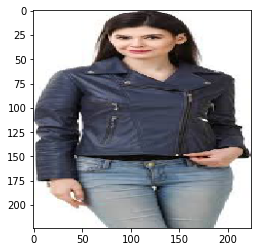

In [ ]:
prediction('jacket.jpg')

hoodies&sweatshirts  99.77%
jackets&coats        0.23%
pants                0.00%
jeans                0.00%
knitwear&cardigans   0.00%
tops                 0.00%
blazers              0.00%
skirts               0.00%
dresses              0.00%
shorts               0.00%

graphic              91.97%
floral               7.91%
solid                0.06%
stripes              0.04%
dots                 0.01%
checks               0.00%

blue                 54.64%
green                20.93%
black&white          17.18%
light_pink&beige     5.39%
purple               1.76%
red&pink             0.06%
yellow               0.03%
brown                0.01%
orange               0.00%


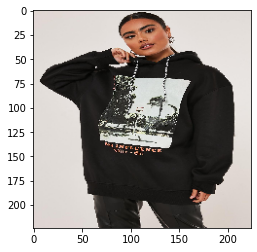

In [ ]:
prediction_details('hoodie.jpg')

dresses              54.60%
jackets&coats        20.71%
knitwear&cardigans   12.12%
skirts               6.04%
tops                 3.02%
pants                2.17%
blazers              0.66%
hoodies&sweatshirts  0.63%
jeans                0.05%
shorts               0.01%

solid                80.66%
stripes              6.25%
floral               4.63%
checks               3.85%
dots                 3.30%
graphic              1.30%

light_pink&beige     47.49%
orange               21.88%
red&pink             17.04%
yellow               7.29%
blue                 2.86%
black&white          1.24%
purple               1.18%
brown                0.53%
green                0.49%


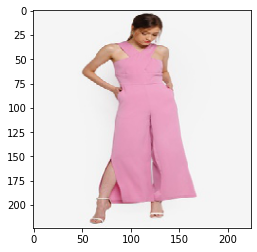

In [ ]:
prediction_details('pink.jpg')

jackets&coats        76.10%
knitwear&cardigans   12.63%
hoodies&sweatshirts  4.49%
blazers              3.87%
tops                 1.59%
pants                1.20%
jeans                0.11%
dresses              0.00%
skirts               0.00%
shorts               0.00%

solid                45.59%
stripes              26.97%
graphic              16.01%
checks               8.01%
dots                 2.55%
floral               0.86%

green                71.00%
black&white          27.11%
light_pink&beige     1.48%
blue                 0.39%
purple               0.02%
yellow               0.00%
brown                0.00%
red&pink             0.00%
orange               0.00%


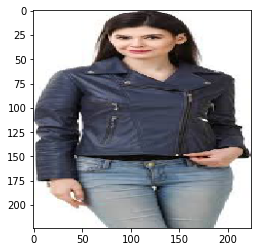

In [ ]:
prediction_details('jacket.jpg')

pants                97.56%
jeans                1.98%
skirts               0.34%
shorts               0.12%
blazers              0.00%
dresses              0.00%
knitwear&cardigans   0.00%
tops                 0.00%
hoodies&sweatshirts  0.00%
jackets&coats        0.00%

stripes              71.87%
dots                 17.58%
graphic              4.63%
solid                4.30%
checks               1.02%
floral               0.60%

black&white          49.68%
blue                 34.32%
green                13.09%
purple               2.66%
light_pink&beige     0.15%
red&pink             0.08%
brown                0.01%
yellow               0.00%
orange               0.00%


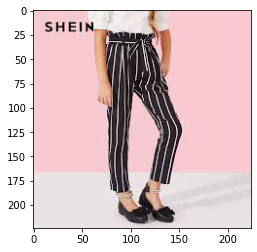

In [ ]:
prediction_details('pants.jpg')

shorts               50.04%
dresses              25.48%
skirts               24.28%
pants                0.13%
knitwear&cardigans   0.05%
tops                 0.01%
jeans                0.00%
blazers              0.00%
hoodies&sweatshirts  0.00%
jackets&coats        0.00%

floral               99.70%
graphic              0.29%
dots                 0.01%
checks               0.00%
solid                0.00%
stripes              0.00%

green                21.73%
orange               15.64%
red&pink             14.06%
black&white          13.42%
blue                 11.02%
yellow               8.25%
light_pink&beige     7.83%
purple               5.31%
brown                2.73%


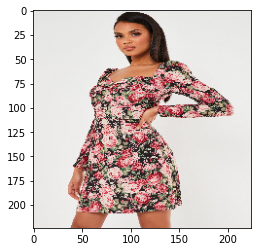

In [ ]:
prediction_details('floral.jpg')

jackets&coats        33.54%
knitwear&cardigans   33.43%
blazers              31.08%
tops                 1.86%
pants                0.07%
hoodies&sweatshirts  0.03%
dresses              0.00%
jeans                0.00%
skirts               0.00%
shorts               0.00%

dots                 74.70%
floral               13.00%
graphic              12.29%
checks               0.01%
solid                0.00%
stripes              0.00%

black&white          43.51%
green                37.79%
blue                 12.42%
light_pink&beige     3.39%
purple               2.56%
brown                0.23%
red&pink             0.06%
yellow               0.03%
orange               0.00%


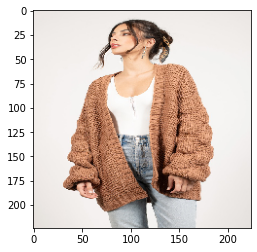

In [ ]:
prediction_details('cardigan.jpg')

skirts               34.77%
dresses              20.61%
shorts               16.52%
knitwear&cardigans   11.63%
pants                7.16%
tops                 2.63%
hoodies&sweatshirts  2.51%
jeans                1.66%
jackets&coats        1.52%
blazers              0.99%

checks               62.48%
solid                11.59%
stripes              10.02%
graphic              7.35%
dots                 4.39%
floral               4.18%

blue                 23.02%
green                21.03%
light_pink&beige     19.17%
black&white          16.11%
purple               8.09%
yellow               4.70%
red&pink             4.18%
brown                2.80%
orange               0.91%


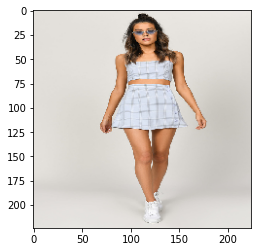

In [ ]:
prediction_details('skirt.jpg')

skirts               34.56%
knitwear&cardigans   24.18%
dresses              23.52%
jackets&coats        9.85%
pants                5.04%
tops                 1.31%
hoodies&sweatshirts  1.12%
shorts               0.15%
blazers              0.14%
jeans                0.13%

stripes              73.96%
checks               20.64%
graphic              4.71%
solid                0.59%
dots                 0.08%
floral               0.03%

blue                 52.15%
green                24.50%
purple               9.00%
black&white          7.39%
red&pink             3.32%
light_pink&beige     3.28%
brown                0.32%
orange               0.03%
yellow               0.03%


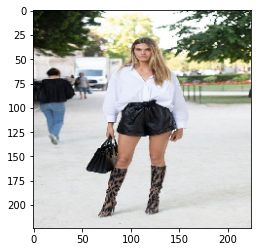

In [ ]:
#test the prediction with background
prediction_details('background.jpg')

hoodies&sweatshirts  35.24%
knitwear&cardigans   24.41%
jackets&coats        11.13%
skirts               10.13%
shorts               6.45%
pants                5.31%
jeans                3.18%
tops                 2.00%
dresses              1.36%
blazers              0.79%

checks               99.85%
stripes              0.14%
graphic              0.00%
solid                0.00%
dots                 0.00%
floral               0.00%

black&white          57.16%
blue                 23.05%
green                13.01%
purple               5.83%
red&pink             0.60%
light_pink&beige     0.19%
brown                0.16%
orange               0.00%
yellow               0.00%


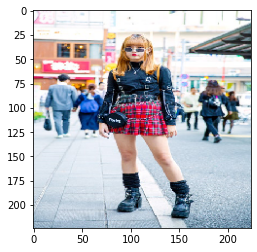

In [ ]:
prediction_details('background2.jpg')